# Imports e leitura do csv

In [1]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')

import io
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
!pip install scikit-plot
import scikitplot as skplt

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

!pip install parameter-sherpa
from sklearn.model_selection import cross_val_score
import time
import sherpa
import sherpa.algorithms.bayesian_optimization as bayesian_optimization

%matplotlib inline

In [2]:
# Importing libraries used for reading csv from cloud
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
# Cloud authentication and getting file
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1u-Dp_ud44EW814B3WZgWpjt3W-jVdRpc"})
downloaded.GetContentFile('TRNcod.csv')

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

In [4]:
# Reading csv, dropping INDEX column and peeking at data
df = pd.read_csv('TRNcod.csv')

df = df.drop(columns = ['INDEX'])
print(df.shape)
df.head()

(389196, 245)


,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,NIVEL_RELACIONAMENTO_CREDITO02,BANCO_REST_IRPF_ULTIMA_1,BANCO_REST_IRPF_ULTIMA_2,BANCO_REST_IRPF_ULTIMA_3,BANCO_REST_IRPF_ULTIMA_4,BANCO_REST_IRPF_ULTIMA_5,BANCO_REST_IRPF_ULTIMA_6,BANCO_REST_IRPF_ULTIMA_7,ATIVIDADE_EMAIL,EXPOSICAO_ENDERECO,EXPOSICAO_EMAIL,EXPOSICAO_TELEFONE,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,EXPOSICAO_CONSUMIDOR_EMAILS,EXPOSICAO_CONSUMIDOR_TELEFONES,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,FLAG_BOLSA_FAMILIA_1,SIGLA_PARTIDO_FILIADO_1,SIGLA_PARTIDO_FILIADO_2,SIGLA_PARTIDO_FILIADO_3,SIGLA_PARTIDO_FILIADO_4,SIGLA_PARTIDO_FILIADO_5,SIGLA_PARTIDO_FILIADO_6,SIGLA_PARTIDO_FILIADO_7,FLAG_FILIADO_PARTIDO_POLITICO_1,FLAG_PROUNI_1,RENDA_VIZINHANCA_1,...,CEP1_3,CEP1_4,CEP1_5,CEP2_1,CEP2_2,CEP2_3,CEP2_4,CEP2_5,CEP2_6,CEP2_7,CEP2_8,CEP2_9,CEP3_1,CEP3_2,CEP3_3,CEP3_4,CEP3_5,CEP3_6,CEP3_7,CEP3_8,CEP3_9,CEP3_10,CEP3_11,CEP3_12,CEP4_1,CEP4_2,CEP4_3,CEP4_4,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,1,1,1,0,0,0,0,0.135098,1,0.222222,0.0,0,0,0,0,0,1,1,5.881235e-18,0.041667,0.000000,0.000000,0.105588,0.796392,-5.140958e-17,0.0,0.1,1.316491e-01,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.013889,0.000000,0.000000,0.147356,0.979968,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,0.0,0,0,0,0,0,1,1,5.881235e-18,0.500000,0.000000,0.000000,0.147356,0.398645,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,0.0,1,1,0,0,0,0,0,4.788559e-01,0.083333,0.115789,0.055556,0.147356,0.398645,8.325188e-02,0.2,0.3,4.859488e-01,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.208333,0.000000,0.111111,0.151604,0.398645,-5.140958e-17,0.0,0.5,1.689438e-01,0.458333,1,1,1,1,0,0,0,0,0,1,0,...,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0


# Mixer de dados

In [5]:
#separando os dados da classe IND_BOM_1_1
dfClass1 = df[df['IND_BOM_1_1']==1]
print(dfClass1.shape)
dfClass1.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


(255098, 245)


,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,NIVEL_RELACIONAMENTO_CREDITO02,BANCO_REST_IRPF_ULTIMA_1,BANCO_REST_IRPF_ULTIMA_2,BANCO_REST_IRPF_ULTIMA_3,BANCO_REST_IRPF_ULTIMA_4,BANCO_REST_IRPF_ULTIMA_5,BANCO_REST_IRPF_ULTIMA_6,BANCO_REST_IRPF_ULTIMA_7,ATIVIDADE_EMAIL,EXPOSICAO_ENDERECO,EXPOSICAO_EMAIL,EXPOSICAO_TELEFONE,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,EXPOSICAO_CONSUMIDOR_EMAILS,EXPOSICAO_CONSUMIDOR_TELEFONES,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,FLAG_BOLSA_FAMILIA_1,SIGLA_PARTIDO_FILIADO_1,SIGLA_PARTIDO_FILIADO_2,SIGLA_PARTIDO_FILIADO_3,SIGLA_PARTIDO_FILIADO_4,SIGLA_PARTIDO_FILIADO_5,SIGLA_PARTIDO_FILIADO_6,SIGLA_PARTIDO_FILIADO_7,FLAG_FILIADO_PARTIDO_POLITICO_1,FLAG_PROUNI_1,RENDA_VIZINHANCA_1,...,CEP1_3,CEP1_4,CEP1_5,CEP2_1,CEP2_2,CEP2_3,CEP2_4,CEP2_5,CEP2_6,CEP2_7,CEP2_8,CEP2_9,CEP3_1,CEP3_2,CEP3_3,CEP3_4,CEP3_5,CEP3_6,CEP3_7,CEP3_8,CEP3_9,CEP3_10,CEP3_11,CEP3_12,CEP4_1,CEP4_2,CEP4_3,CEP4_4,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
1,1,0,1,0,0,1,0,0.273504,1,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.013889,0.000000,0.000000,0.147356,0.979968,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,0.0,0,0,0,0,0,1,1,5.881235e-18,0.500000,0.000000,0.000000,0.147356,0.398645,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,0.0,1,1,0,0,0,0,0,4.788559e-01,0.083333,0.115789,0.055556,0.147356,0.398645,8.325188e-02,0.2,0.3,4.859488e-01,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.208333,0.000000,0.111111,0.151604,0.398645,-5.140958e-17,0.0,0.5,1.689438e-01,0.458333,1,1,1,1,0,0,0,0,0,1,0,...,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0
5,0,1,1,0,0,0,1,0.219323,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.041667,0.000000,0.000000,0.147356,0.398645,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,1,0,1,0,1,1,0,0,0,1,1,0,1,0,0,1,1,0


In [6]:
#separando os dados da classe IND_BOM_1_2
dfClass2 = df[df['IND_BOM_1_2']==1]
print(dfClass2.shape)
dfClass2.head()

(134098, 245)


,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,NIVEL_RELACIONAMENTO_CREDITO02,BANCO_REST_IRPF_ULTIMA_1,BANCO_REST_IRPF_ULTIMA_2,BANCO_REST_IRPF_ULTIMA_3,BANCO_REST_IRPF_ULTIMA_4,BANCO_REST_IRPF_ULTIMA_5,BANCO_REST_IRPF_ULTIMA_6,BANCO_REST_IRPF_ULTIMA_7,ATIVIDADE_EMAIL,EXPOSICAO_ENDERECO,EXPOSICAO_EMAIL,EXPOSICAO_TELEFONE,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,EXPOSICAO_CONSUMIDOR_EMAILS,EXPOSICAO_CONSUMIDOR_TELEFONES,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,FLAG_BOLSA_FAMILIA_1,SIGLA_PARTIDO_FILIADO_1,SIGLA_PARTIDO_FILIADO_2,SIGLA_PARTIDO_FILIADO_3,SIGLA_PARTIDO_FILIADO_4,SIGLA_PARTIDO_FILIADO_5,SIGLA_PARTIDO_FILIADO_6,SIGLA_PARTIDO_FILIADO_7,FLAG_FILIADO_PARTIDO_POLITICO_1,FLAG_PROUNI_1,RENDA_VIZINHANCA_1,...,CEP1_3,CEP1_4,CEP1_5,CEP2_1,CEP2_2,CEP2_3,CEP2_4,CEP2_5,CEP2_6,CEP2_7,CEP2_8,CEP2_9,CEP3_1,CEP3_2,CEP3_3,CEP3_4,CEP3_5,CEP3_6,CEP3_7,CEP3_8,CEP3_9,CEP3_10,CEP3_11,CEP3_12,CEP4_1,CEP4_2,CEP4_3,CEP4_4,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,1,1,1,0,0,0,0,0.135098,1,0.222222,0.0,0,0,0,0,0,1,1,5.881235e-18,0.041667,0.000000,0.000000,0.105588,0.796392,-5.140958e-17,0.0,0.1,0.131649,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1
10,1,0,1,1,0,0,0,0.654703,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.333333,0.000000,0.083333,0.147356,0.591956,-5.140958e-17,0.0,0.2,0.085461,0.098958,1,1,1,1,0,0,0,0,0,1,0,...,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1,0,1,1,1,1,0,1,0,1,0,0,0,0,0,1
11,1,1,1,0,0,0,0,0.097444,1,0.111111,0.0,0,0,0,0,0,1,1,6.589801e-01,0.027778,0.136842,0.083333,0.151604,0.815862,8.325188e-02,0.6,0.4,0.677012,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1
12,1,0,1,0,1,0,0,0.398961,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.013889,0.000000,0.055556,0.151604,0.850630,-5.140958e-17,0.0,0.3,0.168944,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,0,0,1,1,1,0,1,0,1,0,0,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,0,1
17,1,1,1,0,0,0,0,0.142254,0,0.111111,0.0,0,0,0,0,0,1,1,2.162425e-01,125.000000,0.042105,0.111111,0.152312,0.160831,2.817388e-01,0.2,0.5,0.169518,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,1,1,0,0,1,0,1,0,1,0,1


In [7]:
#porcentagem de cada classe do DF
print(dfClass1.shape[0]/df.shape[0])
print(dfClass2.shape[0]/df.shape[0])

0.6554486685371895
0.34455133146281053


In [8]:
#dividindo o dataframe da classe 1 em 50% treinamento e 50% teste
from sklearn.model_selection import train_test_split
class1_train, class1_test = train_test_split(dfClass1, test_size = 0.5, random_state = 2)

print("class1_train shape: {}".format(class1_train.shape))
print("class1_test shape: {}".format(class1_test.shape))

class1_train shape: (127549, 245)
class1_test shape: (127549, 245)


In [9]:
#dividindo o dataframe de teste da classe 1 em 25% teste e 25% validação
class1_test, class1_validation = train_test_split(class1_test, test_size = 0.5, random_state =2)

print("class1_test shape: {}".format(class1_test.shape))
print("class1_validation shape: {}".format(class1_validation.shape))

class1_test shape: (63774, 245)
class1_validation shape: (63775, 245)


In [10]:
#repetindo as divisões para a classe 2
class2_train, class2_test = train_test_split(dfClass2, test_size = 0.5, random_state = 2)

print("class2_train shape: {}".format(class2_train.shape))
print("class2_test shape: {}".format(class2_test.shape))

class2_train shape: (67049, 245)
class2_test shape: (67049, 245)


In [11]:
class2_test, class2_validation = train_test_split(class2_test, test_size = 0.5, random_state = 2)

In [12]:
print(class2_test.shape)
print(class2_validation.shape)

(33524, 245)
(33525, 245)


In [13]:
#aumentando o dataframe de treinamento da classe minoritária para o dobro do seu tamanho utilizando de repetição
while (class2_train.shape[0] < class1_train.shape[0]):
    class2_train = class2_train.append(class2_train)

print(class2_train.shape)

(134098, 245)


In [14]:
#removendo dados excedentes
class2_train = class2_train.head(class1_train.shape[0])
print(class1_train.shape[0])
print(class2_train.shape[0])

127549
127549


In [15]:
#repetindo o processo para o dataframe de validação
while (class2_validation.shape[0] < class1_validation.shape[0]):
    class2_validation = class2_validation.append(class2_validation)

print(class2_validation.shape)

(67050, 245)


In [16]:
class2_validation = class2_validation.head(class1_validation.shape[0])
print(class1_validation.shape[0])
print(class2_validation.shape[0])

63775
63775


In [17]:
validation_X = class2_validation.append(class1_validation).sample(frac=1)
train_X = class2_train.append(class1_train).sample(frac=1)
test_X = class2_test.append(class1_test).sample(frac=1)

In [18]:
print(validation_X.shape[0])
print(train_X.shape[0])
print(test_X.shape[0])

127550
255098
97298


In [19]:
# Transformando IND_BOM_1_1 e IND_BOM_1_2 (que são mutualmente exclusivos em uma unica medida, BOM)
# BOM = 0 means IND_BOM_1_1 = 1
# BOM = 1 means IND_BOM_1_2 = 1

validation_Y = validation_X[["IND_BOM_1_1", "IND_BOM_1_2"]]
validation_X = validation_X.drop(['IND_BOM_1_1'], axis=1)
validation_X = validation_X.drop(['IND_BOM_1_2'], axis=1)
validation_Y['BOM'] = validation_Y["IND_BOM_1_2"]
validation_Y = validation_Y.drop(['IND_BOM_1_1'], axis=1)
validation_Y = validation_Y.drop(['IND_BOM_1_2'], axis=1)

train_Y = train_X[["IND_BOM_1_1", "IND_BOM_1_2"]]
train_X = train_X.drop(['IND_BOM_1_1'], axis=1)
train_X = train_X.drop(['IND_BOM_1_2'], axis=1)
train_Y['BOM'] = train_Y["IND_BOM_1_2"]
train_Y = train_Y.drop(['IND_BOM_1_1'], axis=1)
train_Y = train_Y.drop(['IND_BOM_1_2'], axis=1)

test_Y = test_X[["IND_BOM_1_1", "IND_BOM_1_2"]]
test_X = test_X.drop(['IND_BOM_1_1'], axis=1)
test_X = test_X.drop(['IND_BOM_1_2'], axis=1)
test_Y['BOM'] = test_Y["IND_BOM_1_2"]
test_Y = test_Y.drop(['IND_BOM_1_1'], axis=1)
test_Y = test_Y.drop(['IND_BOM_1_2'], axis=1)

# exemple:
validation_Y

,BOM
64369,0
209831,1
145722,0
319368,0
211909,1
...,...
382651,0
387573,1
187162,0
118445,1


In [20]:
# Funções para plotting e etc

def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

## MODELS

In [21]:
input_dim = train_X.shape[1]

In [22]:
# Model basico
def create_sklearn_compatible_model():
    model = Sequential()
    model.add(Dense(20, activation='tanh', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Tuning do model de duas camadas com SGD
def create_sklearn_compatible_model_1():
    model = Sequential()
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate=trial.parameters['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de uma camadas com SGD
def create_sklearn_compatible_model_2():
    model = Sequential()
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate=trial.parameters['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de duas camadas com ADAM
def create_sklearn_compatible_model_3():
    model = Sequential()
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=trial.parameters['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de uma camadas com ADAM
def create_sklearn_compatible_model_4():
    model = Sequential()
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'],
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=trial.parameters['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

Modelo basico

In [23]:
from keras.wrappers.scikit_learn import KerasClassifier
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
mlp_clf_basic = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=128, epochs=100,
                          verbose=1, callbacks=[es])
mlp_clf_basic._estimator_type = "classifier"

Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2324
Epoch 2/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2274
Epoch 3/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2257
Epoch 4/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2246
Epoch 5/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2238
Epoch 6/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2230
Epoch 7/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2225
Epoch 8/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2219
Epoch 9/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2216
Epoch 10/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2211
Epoch 11/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2209
Epoch 12/100
1993/1993 [==============================] - 3s 2ms/step - lo

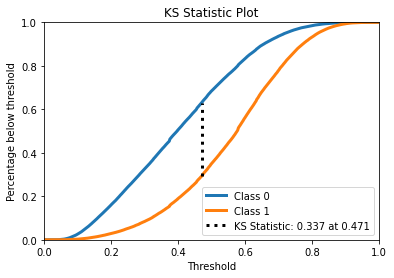

Performance no conjunto de treino:

Accuracy:         0.6671
Recall:           0.6501
Precision:        0.6730
F1:               0.6614
AUROC:            0.7273
AUPR:             0.7028


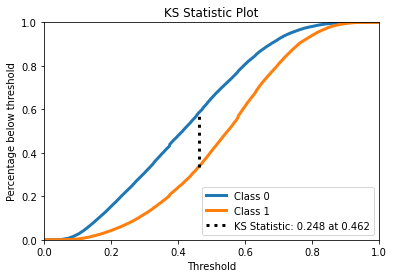

Performance no conjunto de validação:

Accuracy:         0.6219
Recall:           0.5922
Precision:        0.6295
F1:               0.6103
AUROC:            0.6703
AUPR:             0.6478


In [ ]:
#para teste do ensemble
mlp_clf_basic.fit(train_X, train_Y)
mlp_clf_basic.model.save('saved_model_basic.h5')
mlp_clf.fit(train_X, train_Y)
mlp_pred_class = mlp_clf_basic.predict(train_X)
mlp_pred_scores = mlp_clf_basic.predict_proba(train_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de treino:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
mlp_pred_class = mlp_clf_basic.predict(validation_X)
mlp_pred_scores = mlp_clf_basic.predict_proba(validation_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

MLP Tuning com Sherpa

In [ ]:
# Model basico
def create_sklearn_compatible_model():
    model = Sequential()
    model.add(Dense(20, activation='tanh', input_dim=input_dim))
    model.add(Dense(20, activation='tanh', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [24]:
from tensorflow import keras
from tensorflow.keras import layers

parameters = [sherpa.Choice('hidden_layer_sizes', [32,64,128,256]),
              sherpa.Choice('activation', ['tanh', 'relu']),
              sherpa.Continuous('learning_rate', [0.00001, 0.001])]

algorithm = bayesian_optimization.GPyOpt(max_concurrent=1,model_type='GP_MCMC',acquisition_type='EI_MCMC',max_num_trials=10)

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://172.28.0.2:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------


 * Serving Flask app "sherpa.app.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
Trial  1  with parameters  {'hidden_layer_sizes': 128, 'activation': 'relu', 'learning_rate': 0.00014897075191333596}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2460
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2393
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2378
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2367
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2360
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2350
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2345
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2339
Epoch 9/100
3986/3986 [==============================] - 9s 2ms/step - 

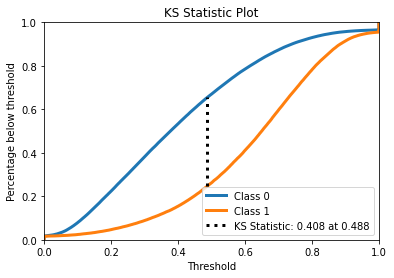

Performance no conjunto de treino:

Accuracy:         0.7039
Recall:           0.7380
Precision:        0.6909
F1:               0.7137
AUROC:            0.7525
AUPR:             0.6950


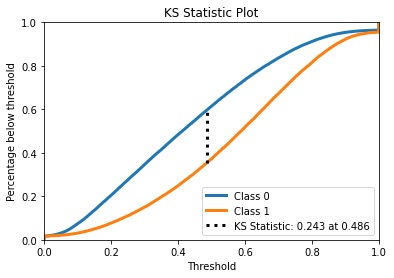

Performance no conjunto de validação:

Accuracy:         0.6213
Recall:           0.6279
Precision:        0.6197
F1:               0.6238
AUROC:            0.6581
AUPR:             0.6177
Trial  2  with parameters  {'hidden_layer_sizes': 32, 'activation': 'tanh', 'learning_rate': 0.000231328992684637}
Epoch 1/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2345
Epoch 2/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2284
Epoch 3/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2273
Epoch 4/100
3986/3986 [==============================] - 6s 1ms/step - loss: 0.2262
Epoch 5/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2253
Epoch 6/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2245
Epoch 7/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2238
Epoch 8/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2231
Epoch 9/100
3986/3986 [=

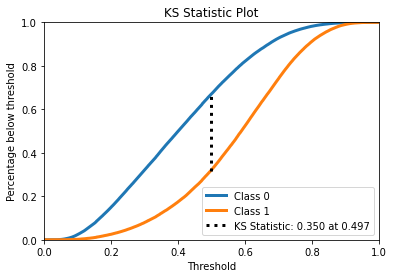

Performance no conjunto de treino:

Accuracy:         0.6748
Recall:           0.6786
Precision:        0.6735
F1:               0.6760
AUROC:            0.7351
AUPR:             0.7127


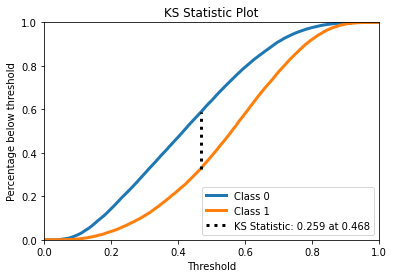

Performance no conjunto de validação:

Accuracy:         0.6278
Recall:           0.6156
Precision:        0.6310
F1:               0.6232
AUROC:            0.6776
AUPR:             0.6561
Trial  3  with parameters  {'hidden_layer_sizes': 128, 'activation': 'tanh', 'learning_rate': 0.0008376007820079858}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2313
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2267
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2249
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2234
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2222
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2212
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2202
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2191
Epoch 9/100
3986/3986 

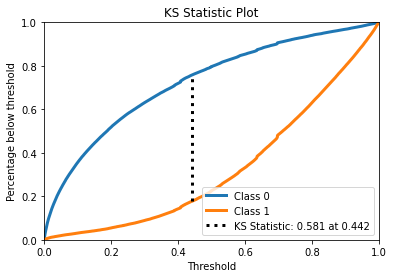

Performance no conjunto de treino:

Accuracy:         0.7854
Recall:           0.7743
Precision:        0.7919
F1:               0.7830
AUROC:            0.8523
AUPR:             0.8168


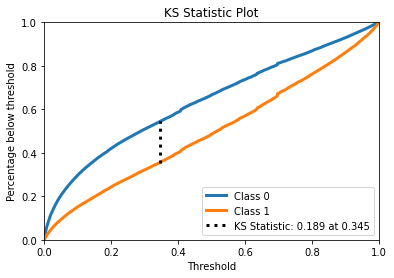

Performance no conjunto de validação:

Accuracy:         0.5904
Recall:           0.5141
Precision:        0.6066
F1:               0.5566
AUROC:            0.6291
AUPR:             0.6085
Trial  4  with parameters  {'hidden_layer_sizes': 128, 'activation': 'tanh', 'learning_rate': 0.0004090311213853634}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2313
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2276
Epoch 3/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2257
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2243
Epoch 5/100
3986/3986 [==============================] - 10s 3ms/step - loss: 0.2231
Epoch 6/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2222
Epoch 7/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2214
Epoch 8/100
3986/3986 [==============================] - 10s 3ms/step - loss: 0.2206
Epoch 9/100
3986/3

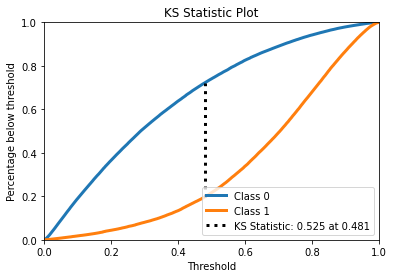

Performance no conjunto de treino:

Accuracy:         0.7618
Recall:           0.7834
Precision:        0.7510
F1:               0.7668
AUROC:            0.8259
AUPR:             0.7946


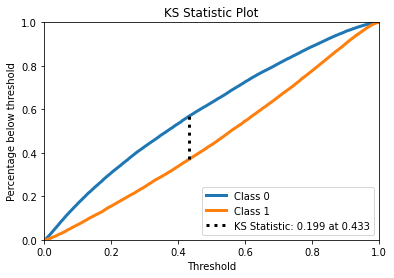

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.5970
Recall:           0.5634
Precision:        0.6040
F1:               0.5830
AUROC:            0.6360
AUPR:             0.6168
Trial  5  with parameters  {'hidden_layer_sizes': 32, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2586
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2448
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2391
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2361
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2344
Epoch 6/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2332
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2323
Epoch 8/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2316
Epoch 9/100
3986/3986 [================

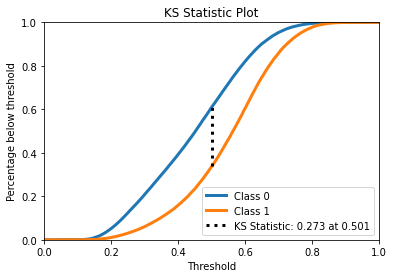

Performance no conjunto de treino:

Accuracy:         0.6362
Recall:           0.6638
Precision:        0.6290
F1:               0.6460
AUROC:            0.6858
AUPR:             0.6649


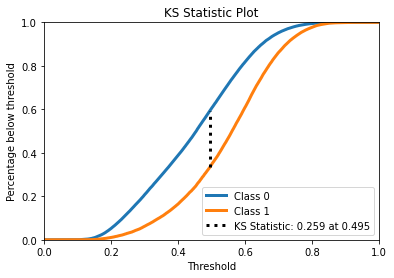

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6295
Recall:           0.6549
Precision:        0.6232
F1:               0.6387
AUROC:            0.6790
AUPR:             0.6582
Trial  6  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 1.5242317551969889e-05}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2605
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2495
Epoch 3/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2450
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2420
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2401
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2386
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2376
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2368
Epoch 9/100
3986/3986 

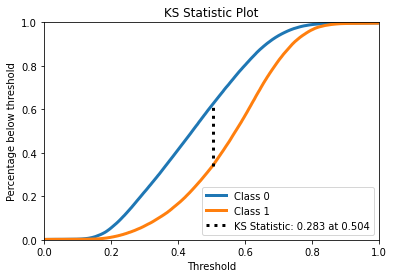

Performance no conjunto de treino:

Accuracy:         0.6412
Recall:           0.6664
Precision:        0.6345
F1:               0.6501
AUROC:            0.6907
AUPR:             0.6629


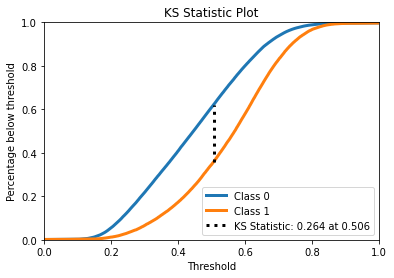

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6316
Recall:           0.6545
Precision:        0.6258
F1:               0.6398
AUROC:            0.6816
AUPR:             0.6545
Trial  7  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2468
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2402
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2370
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2337
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2309
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2302
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2286
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2280
Epoch 9/100
3986/3986 [================

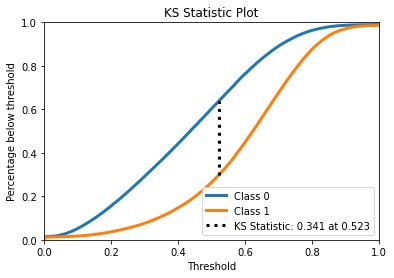

Performance no conjunto de treino:

Accuracy:         0.6696
Recall:           0.7363
Precision:        0.6497
F1:               0.6903
AUROC:            0.7232
AUPR:             0.6862


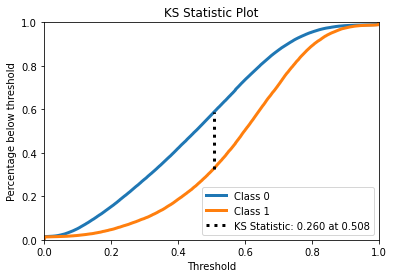

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6294
Recall:           0.6837
Precision:        0.6167
F1:               0.6484
AUROC:            0.6724
AUPR:             0.6366
Trial  8  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2700
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2584
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2532
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2454
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2398
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2381
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2367
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2355
Epoch 9/100
3986/3986 [================

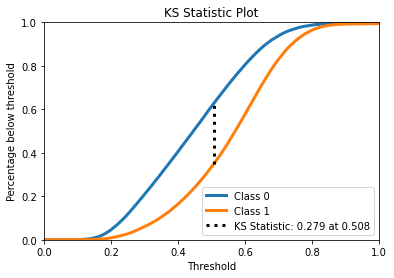

Performance no conjunto de treino:

Accuracy:         0.6392
Recall:           0.6654
Precision:        0.6323
F1:               0.6484
AUROC:            0.6880
AUPR:             0.6571


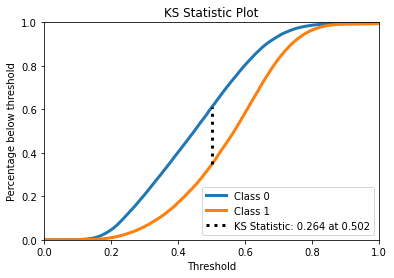

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6319
Recall:           0.6552
Precision:        0.6260
F1:               0.6403
AUROC:            0.6810
AUPR:             0.6510
Trial  9  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2745
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2651
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2542
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2510
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2488
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2474
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2461
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2448
Epoch 9/100
3986/3986 [================

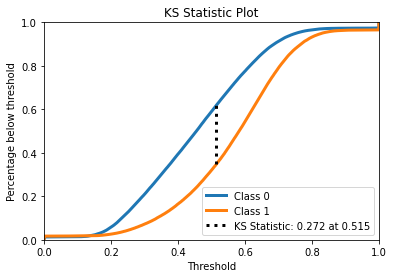

Performance no conjunto de treino:

Accuracy:         0.6349
Recall:           0.6800
Precision:        0.6238
F1:               0.6507
AUROC:            0.6768
AUPR:             0.6383


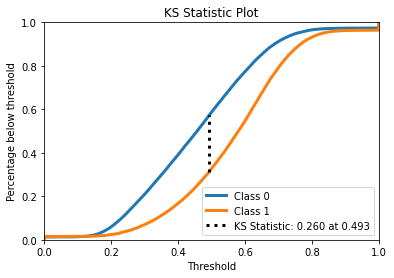

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6297
Recall:           0.6729
Precision:        0.6193
F1:               0.6450
AUROC:            0.6727
AUPR:             0.6348
Trial  10  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2690
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2581
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2505
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2439
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2413
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2395
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2379
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2366
Epoch 9/100
3986/3986 [===============

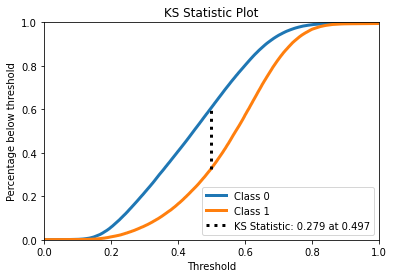

Performance no conjunto de treino:

Accuracy:         0.6397
Recall:           0.6708
Precision:        0.6315
F1:               0.6506
AUROC:            0.6886
AUPR:             0.6594


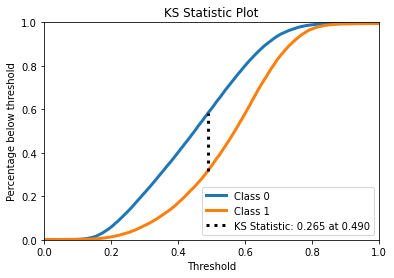

Performance no conjunto de validação:

Accuracy:         0.6320
Recall:           0.6611
Precision:        0.6248
F1:               0.6424
AUROC:            0.6808
AUPR:             0.6516
{'Trial-ID': 10, 'Iteration': 1, 'activation': 'relu', 'hidden_layer_sizes': 32, 'learning_rate': 1e-05, 'Objective': 0.6320109760878087}


In [ ]:
## 1 LAYER - ADAM
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model_4, 
                          batch_size=64, epochs=100)
    mlp_clf.fit(train_X, train_Y)
    mlp_pred_class = mlp_clf.predict(train_X)
    mlp_pred_scores = mlp_clf.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf.predict(validation_X)
    mlp_pred_scores = mlp_clf.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    study.add_observation(trial,
                          iteration=1,
                          objective=accuracy)
    study.finalize(trial)
print(study.get_best_result())

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://172.28.0.2:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------


 * Serving Flask app "sherpa.app.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
Trial  1  with parameters  {'hidden_layer_sizes': 32, 'activation': 'tanh', 'learning_rate': 0.0008709631800860401}
Epoch 1/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2305
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2259
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2242
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2229
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2219
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2211
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2203
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2195
Epoch 9/100
3986/3986 [==============================] - 8s 2ms/step - lo

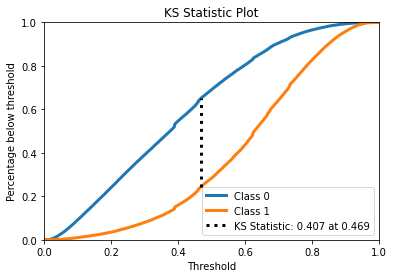

Performance no conjunto de treino:

Accuracy:         0.7035
Recall:           0.7171
Precision:        0.6981
F1:               0.7075
AUROC:            0.7690
AUPR:             0.7433


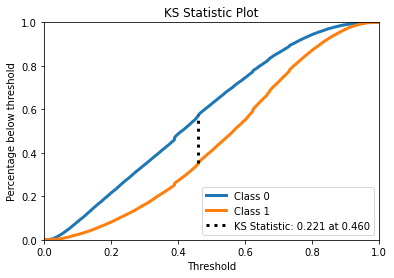

Performance no conjunto de validação:

Accuracy:         0.6080
Recall:           0.5916
Precision:        0.6116
F1:               0.6015
AUROC:            0.6496
AUPR:             0.6263
Trial  2  with parameters  {'hidden_layer_sizes': 32, 'activation': 'tanh', 'learning_rate': 0.0008124009189887667}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2312
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2263
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2244
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2231
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2219
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2210
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2202
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2197
Epoch 9/100
3986/3986 [

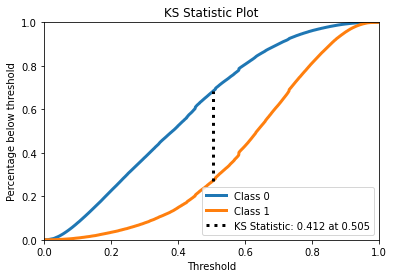

Performance no conjunto de treino:

Accuracy:         0.7058
Recall:           0.7344
Precision:        0.6946
F1:               0.7140
AUROC:            0.7707
AUPR:             0.7459


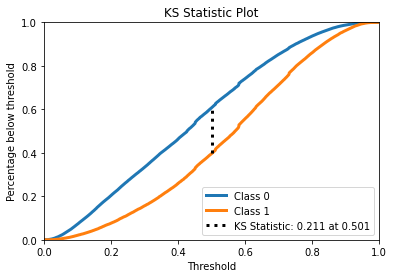

Performance no conjunto de validação:

Accuracy:         0.6055
Recall:           0.6043
Precision:        0.6058
F1:               0.6050
AUROC:            0.6465
AUPR:             0.6247
Trial  3  with parameters  {'hidden_layer_sizes': 128, 'activation': 'relu', 'learning_rate': 0.0007845871713611148}
Epoch 1/100
3986/3986 [==============================] - 12s 3ms/step - loss: 0.2532
Epoch 2/100
3986/3986 [==============================] - 10s 3ms/step - loss: 0.2409
Epoch 3/100
3986/3986 [==============================] - 12s 3ms/step - loss: 0.2347
Epoch 4/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2312
Epoch 5/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2284
Epoch 6/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2254
Epoch 7/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2198
Epoch 8/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2185
Epoch 9/100
3986

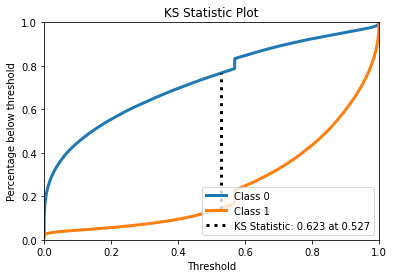

Performance no conjunto de treino:

Accuracy:         0.8107
Recall:           0.8693
Precision:        0.7781
F1:               0.8212
AUROC:            0.8707
AUPR:             0.8400


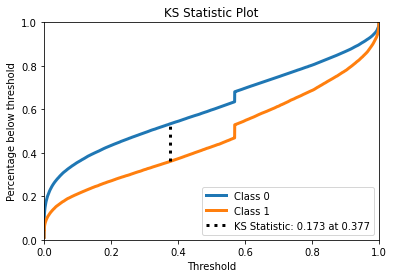

Performance no conjunto de validação:

Accuracy:         0.5849
Recall:           0.5724
Precision:        0.5870
F1:               0.5796
AUROC:            0.6112
AUPR:             0.5854
Trial  4  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.0005520184306063196}
Epoch 1/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2441
Epoch 2/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2337
Epoch 3/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2310
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2289
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2263
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2232
Epoch 7/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2211
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2204
Epoch 9/100
3986/3986 [

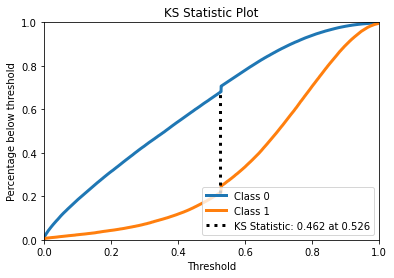

Performance no conjunto de treino:

Accuracy:         0.7297
Recall:           0.8080
Precision:        0.6985
F1:               0.7493
AUROC:            0.7975
AUPR:             0.7655


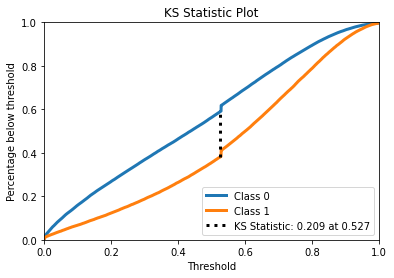

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6038
Recall:           0.6453
Precision:        0.5959
F1:               0.6196
AUROC:            0.6397
AUPR:             0.6132
Trial  5  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2453
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2367
Epoch 3/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2338
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2322
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2311
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2303
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2297
Epoch 8/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2293
Epoch 9/100
3986/3986 [================

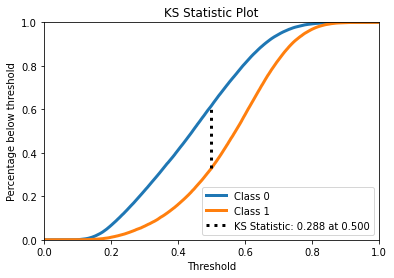

Performance no conjunto de treino:

Accuracy:         0.6441
Recall:           0.6711
Precision:        0.6367
F1:               0.6534
AUROC:            0.6962
AUPR:             0.6753


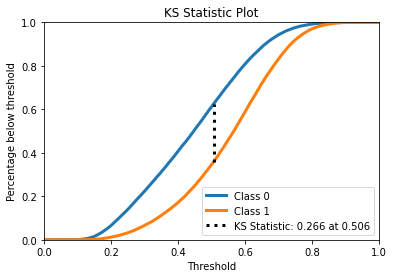

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6328
Recall:           0.6540
Precision:        0.6273
F1:               0.6404
AUROC:            0.6841
AUPR:             0.6624
Trial  6  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 0.001}
Epoch 1/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2305
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2259
Epoch 3/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2241
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2228
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2215
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2203
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2194
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2180
Epoch 9/100
3986/3986 [================

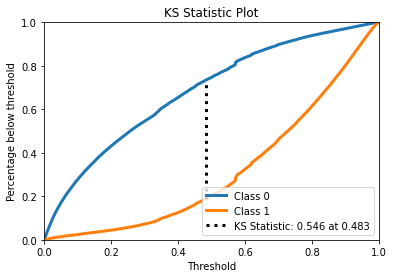

Performance no conjunto de treino:

Accuracy:         0.7726
Recall:           0.7979
Precision:        0.7595
F1:               0.7782
AUROC:            0.8426
AUPR:             0.8131


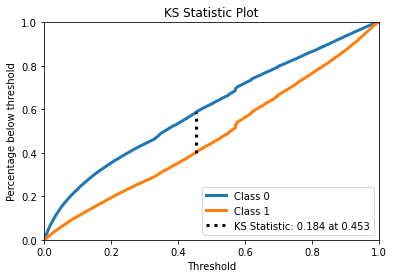

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.5903
Recall:           0.5557
Precision:        0.5970
F1:               0.5756
AUROC:            0.6252
AUPR:             0.6031
Trial  7  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 10s 2ms/step - loss: 0.2482
Epoch 2/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2378
Epoch 3/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2343
Epoch 4/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2325
Epoch 5/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2313
Epoch 6/100
3986/3986 [==============================] - 10s 2ms/step - loss: 0.2304
Epoch 7/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2298
Epoch 8/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2292
Epoch 9/100
3986/3986 [==============

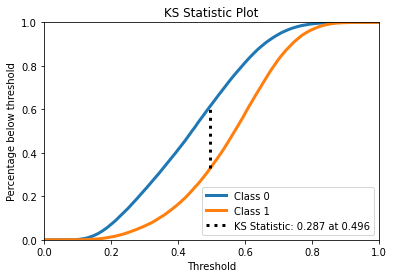

Performance no conjunto de treino:

Accuracy:         0.6430
Recall:           0.6638
Precision:        0.6373
F1:               0.6503
AUROC:            0.6961
AUPR:             0.6754


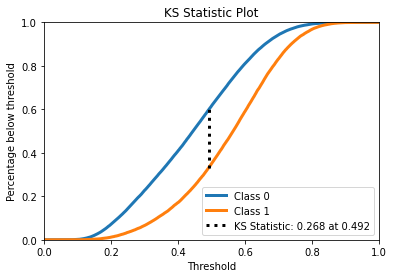

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6328
Recall:           0.6501
Precision:        0.6284
F1:               0.6390
AUROC:            0.6850
AUPR:             0.6639
Trial  8  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2466
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2371
Epoch 3/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2340
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2324
Epoch 5/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2313
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2305
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2299
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2294
Epoch 9/100
3986/3986 [================

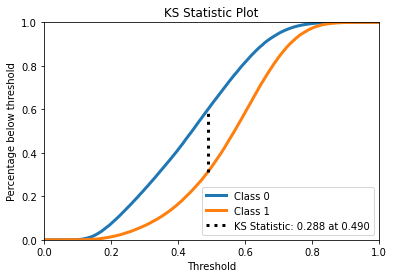

Performance no conjunto de treino:

Accuracy:         0.6437
Recall:           0.6654
Precision:        0.6377
F1:               0.6513
AUROC:            0.6955
AUPR:             0.6746


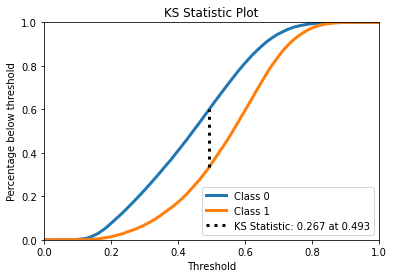

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6323
Recall:           0.6497
Precision:        0.6278
F1:               0.6386
AUROC:            0.6838
AUPR:             0.6632
Trial  9  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2471
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2368
Epoch 3/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2336
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2319
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2309
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2302
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2297
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2292
Epoch 9/100
3986/3986 [===============

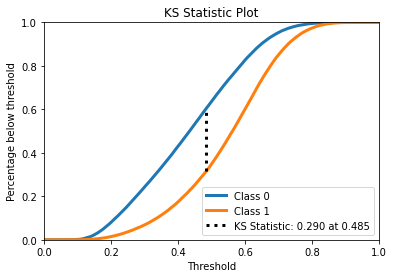

Performance no conjunto de treino:

Accuracy:         0.6442
Recall:           0.6522
Precision:        0.6419
F1:               0.6470
AUROC:            0.6958
AUPR:             0.6746


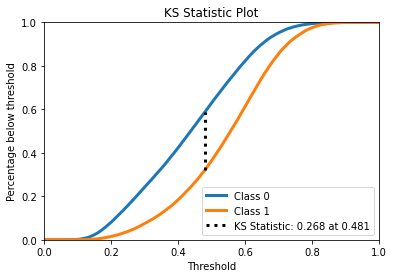

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6328
Recall:           0.6367
Precision:        0.6318
F1:               0.6342
AUROC:            0.6837
AUPR:             0.6629
Trial  10  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2486
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2380
Epoch 3/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2343
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2325
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2313
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2305
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2299
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2294
Epoch 9/100
3986/3986 [===============

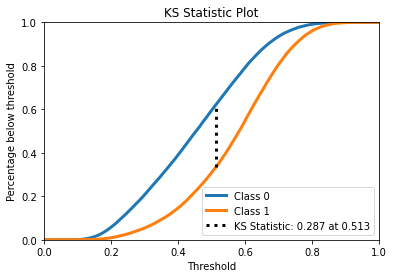

Performance no conjunto de treino:

Accuracy:         0.6431
Recall:           0.6915
Precision:        0.6304
F1:               0.6596
AUROC:            0.6960
AUPR:             0.6746


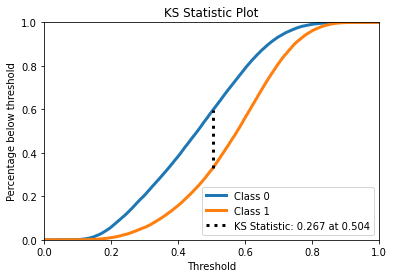

Performance no conjunto de validação:

Accuracy:         0.6328
Recall:           0.6781
Precision:        0.6218
F1:               0.6487
AUROC:            0.6838
AUPR:             0.6641
{'Trial-ID': 9, 'Iteration': 1, 'activation': 'tanh', 'hidden_layer_sizes': 64, 'learning_rate': 1e-05, 'Objective': 0.6328185025480204}


In [ ]:
## 2 LAYERS - ADAM
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model_3, 
                          batch_size=64, epochs=100)
    mlp_clf.fit(train_X, train_Y)
    mlp_pred_class = mlp_clf.predict(train_X)
    mlp_pred_scores = mlp_clf.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf.predict(validation_X)
    mlp_pred_scores = mlp_clf.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    study.add_observation(trial,
                          iteration=1,
                          objective=accuracy)
    study.finalize(trial)
print(study.get_best_result())

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://172.28.0.2:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------


 * Serving Flask app "sherpa.app.app" (lazy loading)
 * Environment: production
 * Debug mode: on
   Use a production WSGI server instead.
Trial  1  with parameters  {'hidden_layer_sizes': 128, 'activation': 'relu', 'learning_rate': 0.00046094226952929086}
Epoch 1/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2879
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2805
Epoch 3/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2780
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2759
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2741
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2721
Epoch 7/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2643
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2623
Epoch 9/100
1993/1993 [==============================] - 4s 2ms/step - 

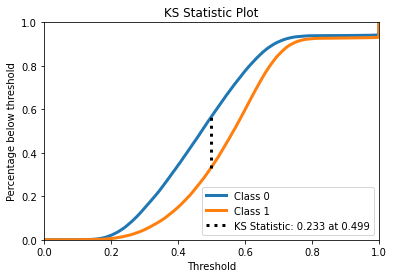

Performance no conjunto de treino:

Accuracy:         0.6165
Recall:           0.6663
Precision:        0.6060
F1:               0.6347
AUROC:            0.6495
AUPR:             0.6014


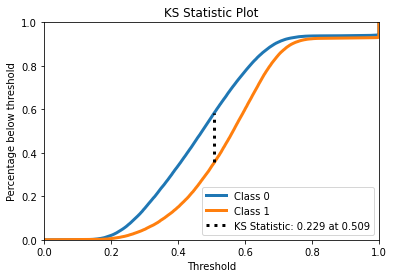

Performance no conjunto de validação:

Accuracy:         0.6136
Recall:           0.6631
Precision:        0.6033
F1:               0.6318
AUROC:            0.6470
AUPR:             0.5999
Trial  2  with parameters  {'hidden_layer_sizes': 128, 'activation': 'tanh', 'learning_rate': 0.0006130681952108678}
Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2665
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2573
Epoch 3/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2542
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2519
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2499
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2482
Epoch 7/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2467
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2455
Epoch 9/100
1993/1993 

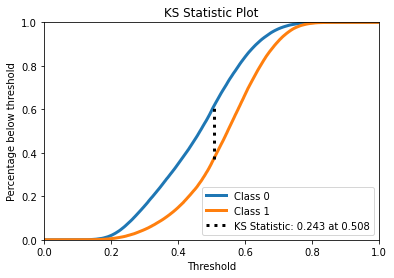

Performance no conjunto de treino:

Accuracy:         0.6210
Recall:           0.6491
Precision:        0.6146
F1:               0.6313
AUROC:            0.6661
AUPR:             0.6437


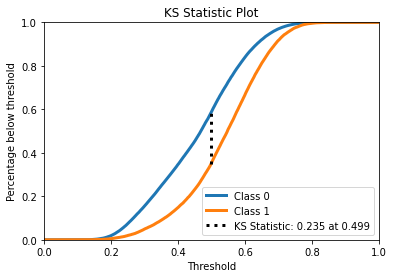

Performance no conjunto de validação:

Accuracy:         0.6175
Recall:           0.6469
Precision:        0.6110
F1:               0.6284
AUROC:            0.6631
AUPR:             0.6405
Trial  3  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 0.0007777739630473011}
Epoch 1/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2563
Epoch 2/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2521
Epoch 3/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2494
Epoch 4/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2474
Epoch 5/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2458
Epoch 6/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2445
Epoch 7/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2433
Epoch 8/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2424
Epoch 9/100
1993/1993 [

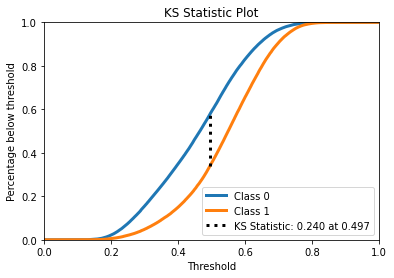

Performance no conjunto de treino:

Accuracy:         0.6190
Recall:           0.6484
Precision:        0.6124
F1:               0.6299
AUROC:            0.6638
AUPR:             0.6413


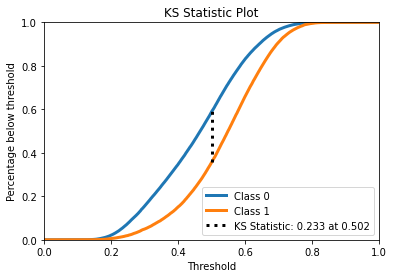

Performance no conjunto de validação:

Accuracy:         0.6163
Recall:           0.6450
Precision:        0.6100
F1:               0.6270
AUROC:            0.6610
AUPR:             0.6385
Trial  4  with parameters  {'hidden_layer_sizes': 256, 'activation': 'tanh', 'learning_rate': 0.0006894045823347668}
Epoch 1/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2561
Epoch 2/100
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2492
Epoch 3/100
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2461
Epoch 4/100
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2439
Epoch 5/100
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2421
Epoch 6/100
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2407
Epoch 7/100
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2395
Epoch 8/100
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2386
Epoch 9/100
1993/1993 

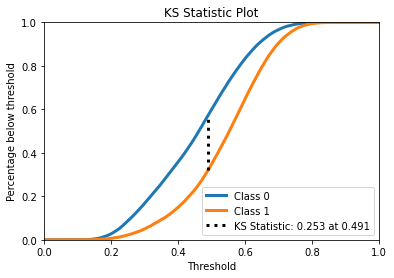

Performance no conjunto de treino:

Accuracy:         0.6257
Recall:           0.6529
Precision:        0.6192
F1:               0.6356
AUROC:            0.6717
AUPR:             0.6491


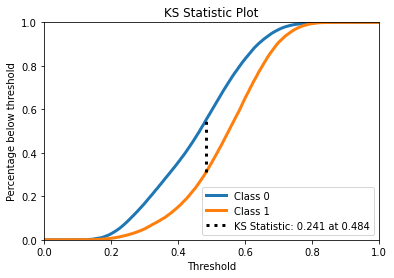

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6203
Recall:           0.6472
Precision:        0.6142
F1:               0.6303
AUROC:            0.6671
AUPR:             0.6446
Trial  5  with parameters  {'hidden_layer_sizes': 256, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2646
Epoch 2/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2633
Epoch 3/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2622
Epoch 4/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2614
Epoch 5/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2608
Epoch 6/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2603
Epoch 7/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2599
Epoch 8/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2596
Epoch 9/100
1993/1993 [===============

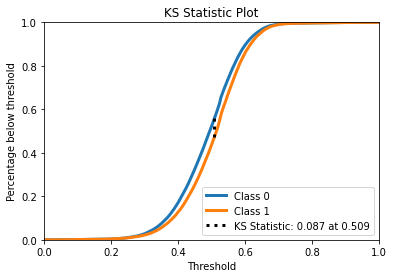

Performance no conjunto de treino:

Accuracy:         0.5433
Recall:           0.5651
Precision:        0.5415
F1:               0.5531
AUROC:            0.5567
AUPR:             0.5438


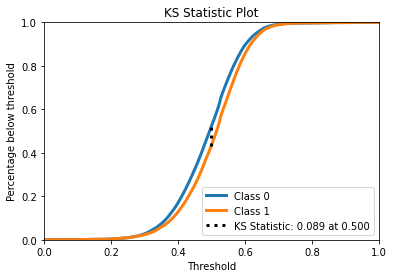

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.5442
Recall:           0.5653
Precision:        0.5424
F1:               0.5536
AUROC:            0.5582
AUPR:             0.5453
Trial  6  with parameters  {'hidden_layer_sizes': 128, 'activation': 'tanh', 'learning_rate': 0.0008054932088485549}
Epoch 1/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2586
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2532
Epoch 3/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2499
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2474
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2454
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2438
Epoch 7/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2424
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2413
Epoch 9/100
1993/1993 

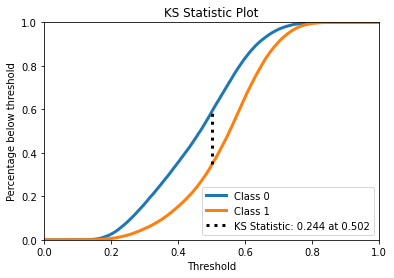

Performance no conjunto de treino:

Accuracy:         0.6220
Recall:           0.6578
Precision:        0.6139
F1:               0.6351
AUROC:            0.6676
AUPR:             0.6454


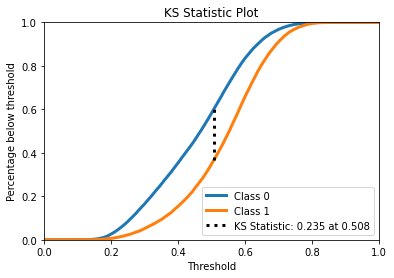

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6171
Recall:           0.6520
Precision:        0.6094
F1:               0.6300
AUROC:            0.6636
AUPR:             0.6409
Trial  7  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2706
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2620
Epoch 3/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2590
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2572
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2554
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2541
Epoch 7/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2518
Epoch 8/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2495
Epoch 9/100
1993/1993 [================

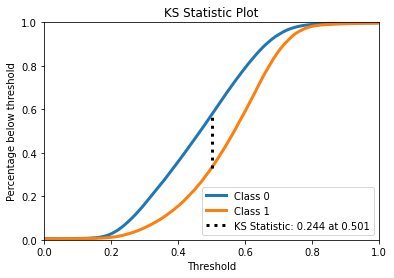

Performance no conjunto de treino:

Accuracy:         0.6221
Recall:           0.6698
Precision:        0.6114
F1:               0.6393
AUROC:            0.6643
AUPR:             0.6334


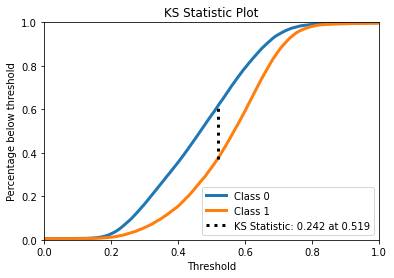

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6204
Recall:           0.6678
Precision:        0.6100
F1:               0.6376
AUROC:            0.6622
AUPR:             0.6319
Trial  8  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2836
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2734
Epoch 3/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2668
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2645
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2624
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2609
Epoch 7/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2594
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2584
Epoch 9/100
1993/1993 [================

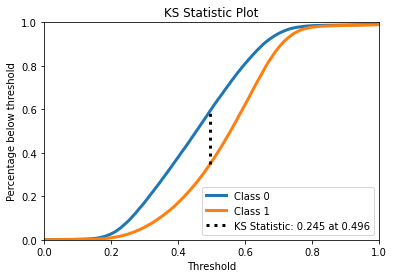

Performance no conjunto de treino:

Accuracy:         0.6218
Recall:           0.6417
Precision:        0.6171
F1:               0.6292
AUROC:            0.6632
AUPR:             0.6276


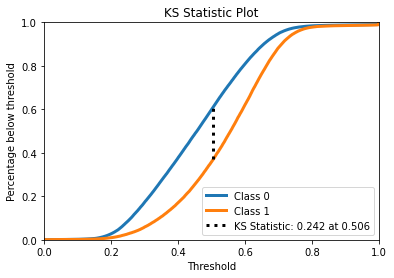

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6206
Recall:           0.6420
Precision:        0.6157
F1:               0.6286
AUROC:            0.6620
AUPR:             0.6267
Trial  9  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2689
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2599
Epoch 3/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2563
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2533
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2513
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2497
Epoch 7/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2482
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2470
Epoch 9/100
1993/1993 [================

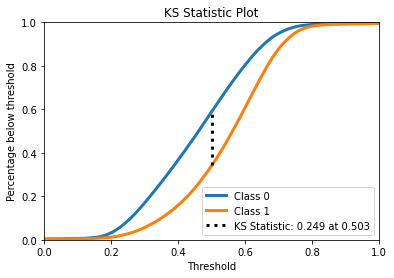

Performance no conjunto de treino:

Accuracy:         0.6243
Recall:           0.6602
Precision:        0.6159
F1:               0.6373
AUROC:            0.6666
AUPR:             0.6352


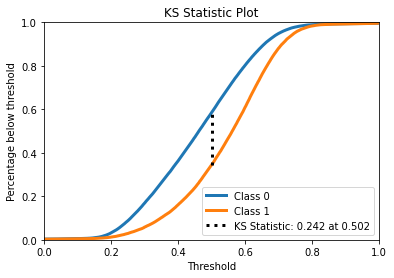

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6208
Recall:           0.6570
Precision:        0.6126
F1:               0.6340
AUROC:            0.6625
AUPR:             0.6296
Trial  10  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2792
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2737
Epoch 3/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2708
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2683
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2665
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2634
Epoch 7/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2548
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2537
Epoch 9/100
1993/1993 [===============

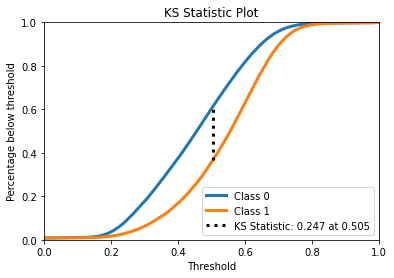

Performance no conjunto de treino:

Accuracy:         0.6232
Recall:           0.6432
Precision:        0.6184
F1:               0.6306
AUROC:            0.6652
AUPR:             0.6385


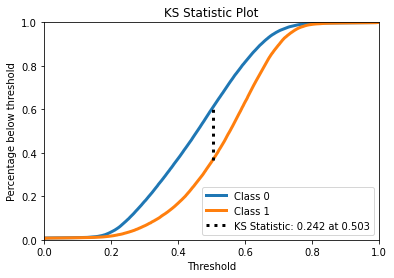

Performance no conjunto de validação:

Accuracy:         0.6206
Recall:           0.6417
Precision:        0.6157
F1:               0.6284
AUROC:            0.6621
AUPR:             0.6354
{'Trial-ID': 9, 'Iteration': 1, 'activation': 'relu', 'hidden_layer_sizes': 64, 'learning_rate': 0.001, 'Objective': 0.6207918463347707}


In [ ]:
## 1 LAYERS - SGD
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model_2, 
                          batch_size=128, epochs=100)
    mlp_clf.fit(train_X, train_Y)
    mlp_pred_class = mlp_clf.predict(train_X)
    mlp_pred_scores = mlp_clf.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf.predict(validation_X)
    mlp_pred_scores = mlp_clf.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    study.add_observation(trial,
                          iteration=1,
                          objective=accuracy)
    study.finalize(trial)
print(study.get_best_result())

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://172.28.0.2:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------


 * Serving Flask app "sherpa.app.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
Trial  1  with parameters  {'hidden_layer_sizes': 128, 'activation': 'relu', 'learning_rate': 0.0007301338455782831}
Epoch 1/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2618
Epoch 2/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2578
Epoch 3/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2554
Epoch 4/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2537
Epoch 5/100
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2524
Epoch 6/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2513
Epoch 7/100
1993/1993 [==============================] - 6s 3ms/step - loss: 0.2503
Epoch 8/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2494
Epoch 9/100
1993/1993 [==============================] - 5s 3ms/step - l

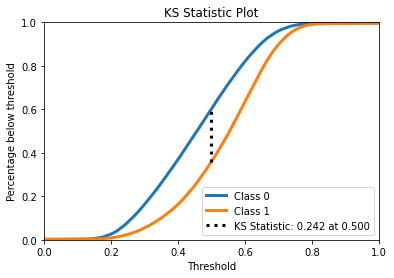

Performance no conjunto de treino:

Accuracy:         0.6212
Recall:           0.6402
Precision:        0.6167
F1:               0.6283
AUROC:            0.6646
AUPR:             0.6366


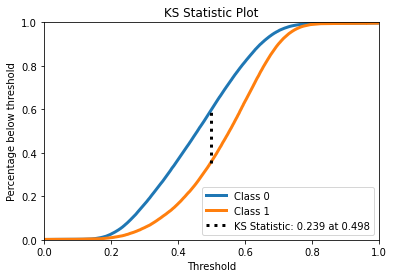

Performance no conjunto de validação:

Accuracy:         0.6192
Recall:           0.6401
Precision:        0.6144
F1:               0.6270
AUROC:            0.6623
AUPR:             0.6346
Trial  2  with parameters  {'hidden_layer_sizes': 256, 'activation': 'relu', 'learning_rate': 0.0006625271377980203}
Epoch 1/100
1993/1993 [==============================] - 10s 5ms/step - loss: 0.2681
Epoch 2/100
1993/1993 [==============================] - 9s 5ms/step - loss: 0.2572
Epoch 3/100
1993/1993 [==============================] - 10s 5ms/step - loss: 0.2531
Epoch 4/100
1993/1993 [==============================] - 9s 5ms/step - loss: 0.2516
Epoch 5/100
1993/1993 [==============================] - 11s 5ms/step - loss: 0.2500
Epoch 6/100
1993/1993 [==============================] - 10s 5ms/step - loss: 0.2487
Epoch 7/100
1993/1993 [==============================] - 10s 5ms/step - loss: 0.2478
Epoch 8/100
1993/1993 [==============================] - 9s 5ms/step - loss: 0.2465
Epoch 9/100
1993/

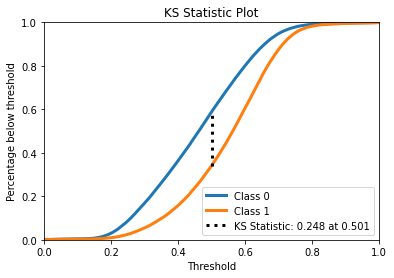

Performance no conjunto de treino:

Accuracy:         0.6239
Recall:           0.6599
Precision:        0.6156
F1:               0.6369
AUROC:            0.6658
AUPR:             0.6341


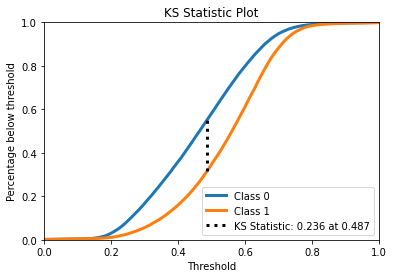

Performance no conjunto de validação:

Accuracy:         0.6168
Recall:           0.6527
Precision:        0.6090
F1:               0.6301
AUROC:            0.6590
AUPR:             0.6256
Trial  3  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 0.000411196226458842}
Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2643
Epoch 2/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2620
Epoch 3/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2609
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2600
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2591
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2586
Epoch 7/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2580
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2575
Epoch 9/100
1993/1993 [=

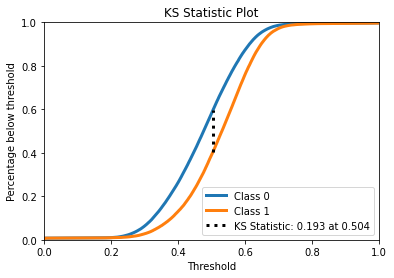

Performance no conjunto de treino:

Accuracy:         0.5962
Recall:           0.6105
Precision:        0.5935
F1:               0.6019
AUROC:            0.6312
AUPR:             0.6071


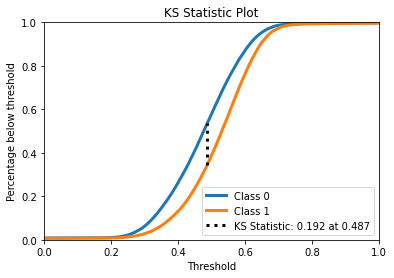

Performance no conjunto de validação:

Accuracy:         0.5947
Recall:           0.6114
Precision:        0.5917
F1:               0.6014
AUROC:            0.6279
AUPR:             0.6028
Trial  4  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.0009043439757971762}
Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2730
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2577
Epoch 3/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2554
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2537
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2525
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2515
Epoch 7/100
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2505
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2496
Epoch 9/100
1993/1993 [

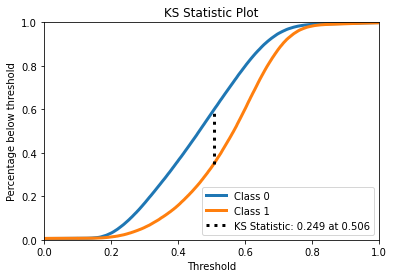

Performance no conjunto de treino:

Accuracy:         0.6241
Recall:           0.6666
Precision:        0.6144
F1:               0.6394
AUROC:            0.6649
AUPR:             0.6333


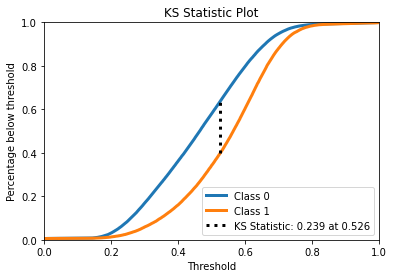

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6187
Recall:           0.6588
Precision:        0.6098
F1:               0.6334
AUROC:            0.6612
AUPR:             0.6290
Trial  5  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2619
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2590
Epoch 3/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2563
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2530
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2519
Epoch 6/100
1993/1993 [==============================] - 5s 3ms/step - loss: 0.2510
Epoch 7/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2500
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2491
Epoch 9/100
1993/1993 [================

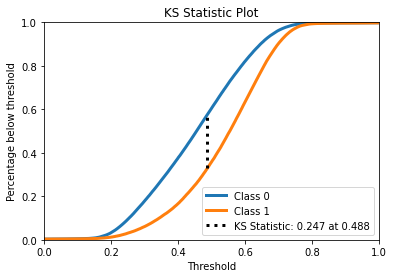

Performance no conjunto de treino:

Accuracy:         0.6234
Recall:           0.6423
Precision:        0.6189
F1:               0.6303
AUROC:            0.6663
AUPR:             0.6389


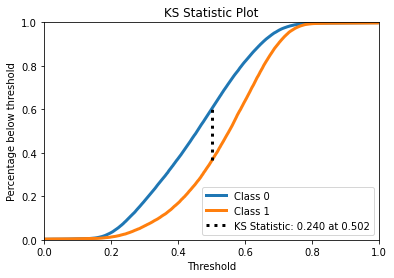

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6196
Recall:           0.6383
Precision:        0.6152
F1:               0.6266
AUROC:            0.6618
AUPR:             0.6343
Trial  6  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
1993/1993 [==============================] - 7s 3ms/step - loss: 0.2660
Epoch 2/100
1993/1993 [==============================] - 7s 3ms/step - loss: 0.2591
Epoch 3/100
1993/1993 [==============================] - 7s 3ms/step - loss: 0.2560
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2526
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2516
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2506
Epoch 7/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2496
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2488
Epoch 9/100
1993/1993 [================

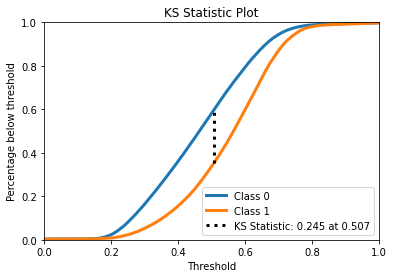

Performance no conjunto de treino:

Accuracy:         0.6221
Recall:           0.6628
Precision:        0.6129
F1:               0.6369
AUROC:            0.6648
AUPR:             0.6305


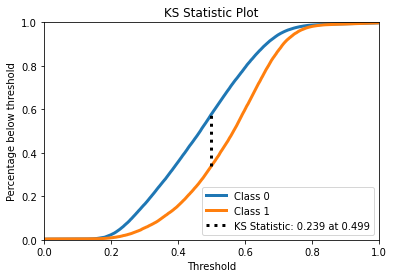

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6194
Recall:           0.6604
Precision:        0.6103
F1:               0.6344
AUROC:            0.6610
AUPR:             0.6265
Trial  7  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2629
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2579
Epoch 3/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2555
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2537
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2524
Epoch 6/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2511
Epoch 7/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2500
Epoch 8/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2490
Epoch 9/100
1993/1993 [================

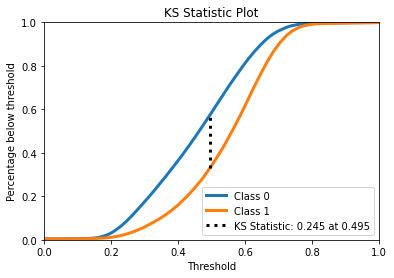

Performance no conjunto de treino:

Accuracy:         0.6220
Recall:           0.6597
Precision:        0.6135
F1:               0.6357
AUROC:            0.6662
AUPR:             0.6397


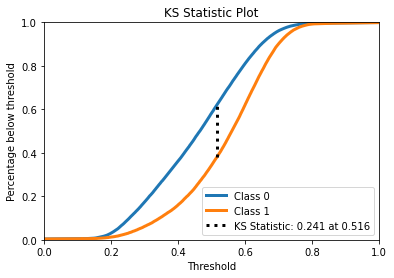

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6197
Recall:           0.6575
Precision:        0.6113
F1:               0.6335
AUROC:            0.6628
AUPR:             0.6355
Trial  8  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2618
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2561
Epoch 3/100
1993/1993 [==============================] - 7s 4ms/step - loss: 0.2537
Epoch 4/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2520
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2507
Epoch 6/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2498
Epoch 7/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2489
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2481
Epoch 9/100
1993/1993 [================

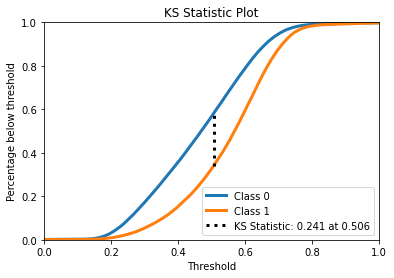

Performance no conjunto de treino:

Accuracy:         0.6202
Recall:           0.6742
Precision:        0.6085
F1:               0.6397
AUROC:            0.6632
AUPR:             0.6299


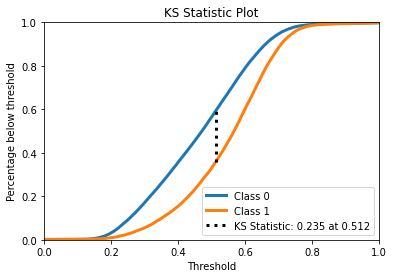

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6174
Recall:           0.6710
Precision:        0.6060
F1:               0.6369
AUROC:            0.6588
AUPR:             0.6244
Trial  9  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2663
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2592
Epoch 3/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2570
Epoch 4/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2556
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2545
Epoch 6/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2534
Epoch 7/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2522
Epoch 8/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2502
Epoch 9/100
1993/1993 [================

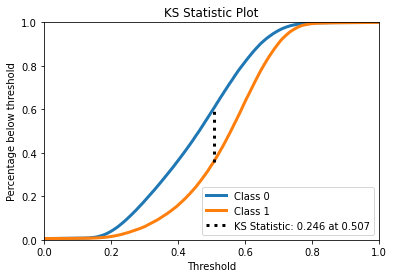

Performance no conjunto de treino:

Accuracy:         0.6224
Recall:           0.6569
Precision:        0.6145
F1:               0.6350
AUROC:            0.6650
AUPR:             0.6382


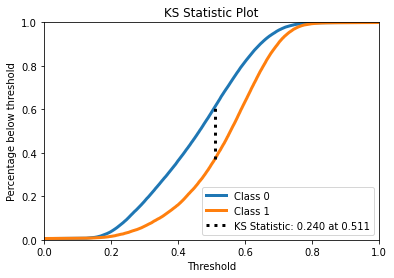

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6196
Recall:           0.6534
Precision:        0.6120
F1:               0.6320
AUROC:            0.6624
AUPR:             0.6374
Trial  10  with parameters  {'hidden_layer_sizes': 128, 'activation': 'tanh', 'learning_rate': 0.0009428252416621975}
Epoch 1/100
1993/1993 [==============================] - 9s 4ms/step - loss: 0.2547
Epoch 2/100
1993/1993 [==============================] - 8s 4ms/step - loss: 0.2489
Epoch 3/100
1993/1993 [==============================] - 8s 4ms/step - loss: 0.2460
Epoch 4/100
1993/1993 [==============================] - 8s 4ms/step - loss: 0.2440
Epoch 5/100
1993/1993 [==============================] - 8s 4ms/step - loss: 0.2425
Epoch 6/100
1993/1993 [==============================] - 7s 3ms/step - loss: 0.2412
Epoch 7/100
1993/1993 [==============================] - 7s 4ms/step - loss: 0.2402
Epoch 8/100
1993/1993 [==============================] - 8s 4ms/step - loss: 0.2393
Epoch 9/100
1993/1993

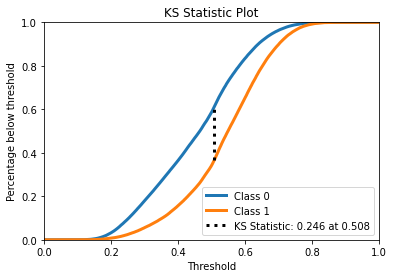

Performance no conjunto de treino:

Accuracy:         0.6224
Recall:           0.6588
Precision:        0.6141
F1:               0.6357
AUROC:            0.6687
AUPR:             0.6459


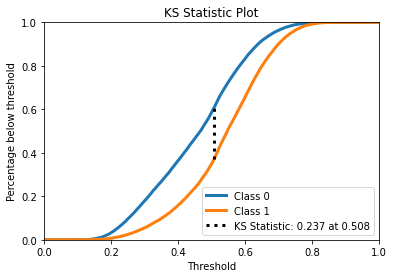

Performance no conjunto de validação:

Accuracy:         0.6176
Recall:           0.6515
Precision:        0.6102
F1:               0.6302
AUROC:            0.6644
AUPR:             0.6422
{'Trial-ID': 7, 'Iteration': 1, 'activation': 'relu', 'hidden_layer_sizes': 64, 'learning_rate': 0.001, 'Objective': 0.6197099176793415}


In [ ]:
## 2 LAYERS - SGD
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model_1, 
                          batch_size=128, epochs=100)
    mlp_clf.fit(train_X, train_Y)
    mlp_pred_class = mlp_clf.predict(train_X)
    mlp_pred_scores = mlp_clf.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf.predict(validation_X)
    mlp_pred_scores = mlp_clf.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    study.add_observation(trial,
                          iteration=1,
                          objective=accuracy)
    study.finalize(trial)
print(study.get_best_result())

In [ ]:
# 1 LAYERS - ADAM - {'Trial-ID': 10, 'Iteration': 1, 'activation': 'relu', 'hidden_layer_sizes': 32, 'learning_rate': 1e-05, 'Objective': 0.6320109760878087}
# 2 LAYERS - ADAM - {'Trial-ID': 9, 'Iteration': 1, 'activation': 'tanh', 'hidden_layer_sizes': 64, 'learning_rate': 1e-05, 'Objective': 0.6328185025480204}

# 1 LAYERS - SGD - {'Trial-ID': 9, 'Iteration': 1, 'activation': 'relu', 'hidden_layer_sizes': 64, 'learning_rate': 0.001, 'Objective': 0.6207918463347707}
# 2 LAYERS - SGD - {'Trial-ID': 7, 'Iteration': 1, 'activation': 'relu', 'hidden_layer_sizes': 64, 'learning_rate': 0.001, 'Objective': 0.6197099176793415}

4 best models with more epochs



In [25]:
# Tuning do model de duas camadas com SGD
def create_sklearn_compatible_model_1():
    model = Sequential()
    model.add(Dense(64, 
                    activation='relu', 
                    input_dim=input_dim))
    model.add(Dense(64, 
                    activation='relu', 
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de uma camadas com SGD
def create_sklearn_compatible_model_2():
    model = Sequential()
    model.add(Dense(64, 
                    activation='relu', 
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de duas camadas com ADAM
def create_sklearn_compatible_model_3():
    model = Sequential()
    model.add(Dense(64, 
                    activation='tanh', 
                    input_dim=input_dim))
    model.add(Dense(64, 
                    activation='tanh',
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=1e-05)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de uma camadas com ADAM
def create_sklearn_compatible_model_4():
    model = Sequential()
    model.add(Dense(32, 
                    activation='relu',
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=1e-05)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [26]:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    mlp_clf_1 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_1, 
                          batch_size=128, epochs=1000,
                          verbose=1, callbacks=[es])
    mlp_clf_1._estimator_type = "classifier"

Epoch 1/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2607
Epoch 2/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2557
Epoch 3/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2542
Epoch 4/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2528
Epoch 5/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2516
Epoch 6/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2506
Epoch 7/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2498
Epoch 8/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2490
Epoch 9/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2483
Epoch 10/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2475
Epoch 11/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2469
Epoch 12/1000
1993/1993 [==============================] - 3s 2

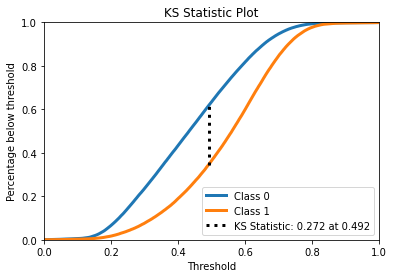

Performance no conjunto de treino:

Accuracy:         0.6353
Recall:           0.6367
Precision:        0.6350
F1:               0.6358
AUROC:            0.6843
AUPR:             0.6600


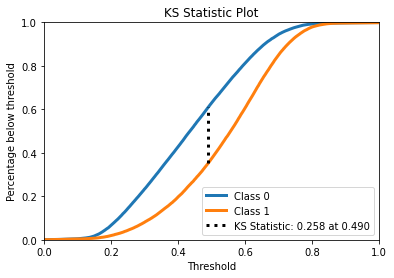

Performance no conjunto de validação:

Accuracy:         0.6282
Recall:           0.6273
Precision:        0.6284
F1:               0.6279
AUROC:            0.6741
AUPR:             0.6491


In [ ]:
    mlp_clf_1.fit(train_X, train_Y)
    mlp_clf_1.model.save('SGD_2_camadas.h5')
    mlp_pred_class = mlp_clf_1.predict(train_X)
    mlp_pred_scores = mlp_clf_1.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf_1.predict(validation_X)
    mlp_pred_scores = mlp_clf_1.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [27]:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    mlp_clf_2 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_2, 
                          batch_size=128, epochs=1000,
                          verbose=1, callbacks=[es])
    mlp_clf_2._estimator_type = "classifier"

Epoch 1/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2782
Epoch 2/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2634
Epoch 3/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2599
Epoch 4/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2580
Epoch 5/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2563
Epoch 6/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2548
Epoch 7/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2534
Epoch 8/1000
1993/1993 [==============================] - 3s 1ms/step - loss: 0.2523
Epoch 9/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2513
Epoch 10/1000
1993/1993 [==============================] - 3s 1ms/step - loss: 0.2505
Epoch 11/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2496
Epoch 12/1000
1993/1993 [==============================] - 3s 2

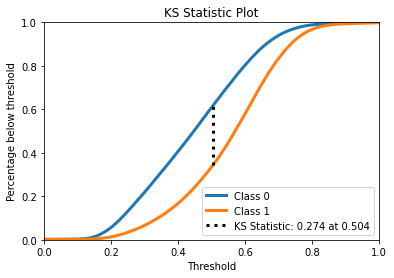

Performance no conjunto de treino:

Accuracy:         0.6368
Recall:           0.6656
Precision:        0.6294
F1:               0.6470
AUROC:            0.6848
AUPR:             0.6556


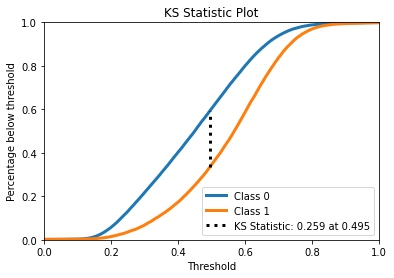

Performance no conjunto de validação:

Accuracy:         0.6289
Recall:           0.6551
Precision:        0.6225
F1:               0.6384
AUROC:            0.6768
AUPR:             0.6486


In [ ]:
    mlp_clf_2.fit(train_X, train_Y)
    mlp_clf_2.model.save('SGD_1_camada.h5')
    mlp_pred_class = mlp_clf_2.predict(train_X)
    mlp_pred_scores = mlp_clf_2.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf_2.predict(validation_X)
    mlp_pred_scores = mlp_clf_2.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [28]:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    mlp_clf_3 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_3, 
                          batch_size=128, epochs=1000,
                          verbose=1, callbacks=[es])
    mlp_clf_3._estimator_type = "classifier"

Epoch 1/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2466
Epoch 2/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2390
Epoch 3/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2358
Epoch 4/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2339
Epoch 5/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2327
Epoch 6/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2318
Epoch 7/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2311
Epoch 8/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2305
Epoch 9/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2300
Epoch 10/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2296
Epoch 11/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2292
Epoch 12/1000
1993/1993 [==============================] - 4s 2

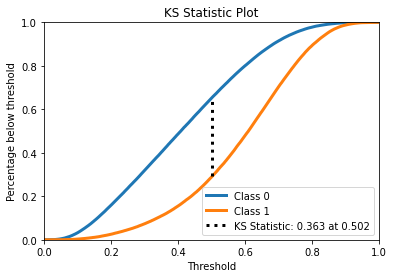

Performance no conjunto de treino:

Accuracy:         0.6815
Recall:           0.7114
Precision:        0.6712
F1:               0.6907
AUROC:            0.7427
AUPR:             0.7198


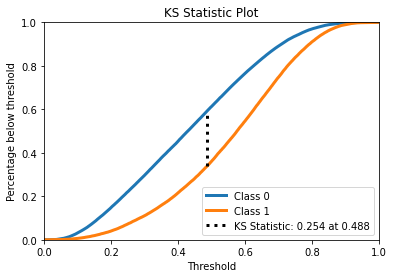

Performance no conjunto de validação:

Accuracy:         0.6262
Recall:           0.6396
Precision:        0.6229
F1:               0.6312
AUROC:            0.6727
AUPR:             0.6488


In [ ]:
    mlp_clf_3.fit(train_X, train_Y)
    mlp_clf_3.model.save('Adam_2_camadas.h5')
    mlp_pred_class = mlp_clf_3.predict(train_X)
    mlp_pred_scores = mlp_clf_3.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf_3.predict(validation_X)
    mlp_pred_scores = mlp_clf_3.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [29]:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    mlp_clf_4 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_4, 
                          batch_size=128, epochs=1000,
                          verbose=1, callbacks=[es])
    mlp_clf_4._estimator_type = "classifier"

Epoch 1/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2652
Epoch 2/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2561
Epoch 3/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2499
Epoch 4/1000
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2473
Epoch 5/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2455
Epoch 6/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2440
Epoch 7/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2428
Epoch 8/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2419
Epoch 9/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2409
Epoch 10/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2402
Epoch 11/1000
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2397
Epoch 12/1000
1993/1993 [==============================] - 3s 2

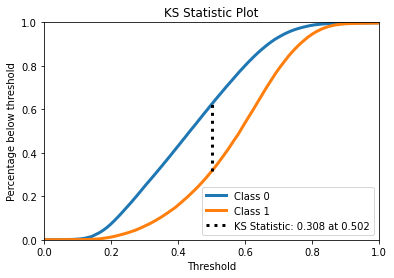

Performance no conjunto de treino:

Accuracy:         0.6538
Recall:           0.6853
Precision:        0.6447
F1:               0.6644
AUROC:            0.7093
AUPR:             0.6829


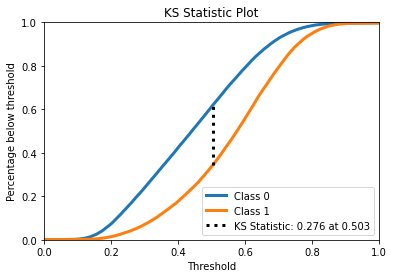

Performance no conjunto de validação:

Accuracy:         0.6374
Recall:           0.6636
Precision:        0.6306
F1:               0.6467
AUROC:            0.6884
AUPR:             0.6612


In [ ]:
    mlp_clf_4.fit(train_X, train_Y)
    mlp_clf_4.model.save('Adam_1_camada.h5')
    mlp_pred_class = mlp_clf_4.predict(train_X)
    mlp_pred_scores = mlp_clf_4.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf_4.predict(validation_X)
    mlp_pred_scores = mlp_clf_4.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Com batchNormalization + dropout

In [ ]:
# Tuning do model de duas camadas com SGD
def create_sklearn_compatible_model_1():
    model = Sequential()
    model.add(Dense(64, 
                    activation='relu', 
                    input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 
    model.add(Dense(64, 
                    activation='relu', 
                    input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate='0.001')
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de uma camadas com SGD
def create_sklearn_compatible_model_2():
    model = Sequential()
    model.add(Dense(64, 
                    activation='relu', 
                    input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate='0.001')
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de duas camadas com ADAM
def create_sklearn_compatible_model_3():
    model = Sequential()
    model.add(Dense(64, 
                    activation='tanh', 
                    input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate='1e-05')
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de uma camadas com ADAM
def create_sklearn_compatible_model_4():
    model = Sequential()
    model.add(Dense(32, 
                    activation='relu',
                    input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate='1e-05')
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [ ]:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    mlp_clf_1 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_1, 
                          batch_size=128, epochs=1000,
                          verbose=1, callbacks=[es])
    mlp_clf_1._estimator_type = "classifier"
    mlp_clf_1.fit(train_X, train_Y)
    mlp_clf_1.model.save('SGD_2_camadas.h5')
    mlp_pred_class = mlp_clf_1.predict(train_X)
    mlp_pred_scores = mlp_clf_1.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf_1.predict(validation_X)
    mlp_pred_scores = mlp_clf_1.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    mlp_clf_2 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_2, 
                          batch_size=128, epochs=1000,
                          verbose=1, callbacks=[es])
    mlp_clf_2._estimator_type = "classifier"
    mlp_clf_2.fit(train_X, train_Y)
    mlp_clf_2.model.save('SGD_1_camada.h5')
    mlp_pred_class = mlp_clf_2.predict(train_X)
    mlp_pred_scores = mlp_clf_2.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf_2.predict(validation_X)
    mlp_pred_scores = mlp_clf_2.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    mlp_clf_3 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_3, 
                          batch_size=128, epochs=1000,
                          verbose=1, callbacks=[es])
    mlp_clf_3._estimator_type = "classifier"
    mlp_clf_3.fit(train_X, train_Y)
    mlp_clf_3.model.save('Adam_2_camadas.h5')
    mlp_pred_class = mlp_clf_3.predict(train_X)
    mlp_pred_scores = mlp_clf_3.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf_3.predict(validation_X)
    mlp_pred_scores = mlp_clf_3.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    mlp_clf_4 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_4, 
                          batch_size=128, epochs=1000,
                          verbose=1, callbacks=[es])
    mlp_clf_4._estimator_type = "classifier"
    mlp_clf_4.fit(train_X, train_Y)
    mlp_clf_4.model.save('Adam_1_camada.h5')
    mlp_pred_class = mlp_clf_4.predict(train_X)
    mlp_pred_scores = mlp_clf_4.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf_4.predict(validation_X)
    mlp_pred_scores = mlp_clf_4.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Ensembles

In [30]:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    mlp_clf_1 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_1, 
                          batch_size=128, epochs=100,
                          verbose=1, callbacks=[es])
    mlp_clf_1._estimator_type = "classifier"

    mlp_clf_2 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_2, 
                          batch_size=128, epochs=100,
                          verbose=1, callbacks=[es])
    mlp_clf_2._estimator_type = "classifier"

    mlp_clf_3 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_3, 
                          batch_size=128, epochs=100,
                          verbose=1, callbacks=[es])
    mlp_clf_3._estimator_type = "classifier"

    mlp_clf_4 = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_4, 
                          batch_size=128, epochs=100,
                          verbose=1, callbacks=[es])
    mlp_clf_4._estimator_type = "classifier"

Epoch 1/100
1993/1993 [==============================] - 5s 2ms/step - loss: 0.2645
Epoch 2/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2592
Epoch 3/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2573
Epoch 4/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2556
Epoch 5/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2526
Epoch 6/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2498
Epoch 7/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2489
Epoch 8/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2482
Epoch 9/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2472
Epoch 10/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2464
Epoch 11/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2457
Epoch 12/100
1993/1993 [==============================] - 4s 2ms/step - lo

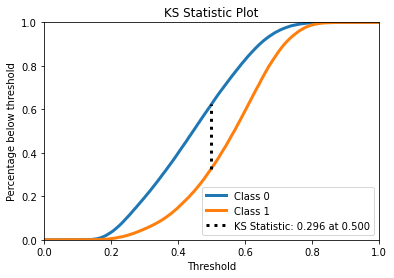

Performance no conjunto de treino:

Accuracy:         0.6481
Recall:           0.6722
Precision:        0.6412
F1:               0.6563
AUROC:            0.7013
AUPR:             0.6808


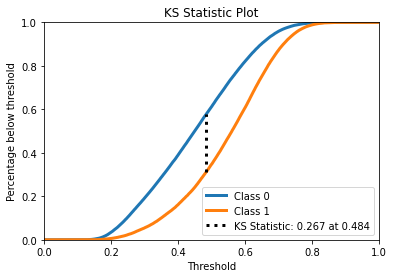

Performance no conjunto de validação:

Accuracy:         0.6324
Recall:           0.6532
Precision:        0.6271
F1:               0.6399
AUROC:            0.6829
AUPR:             0.6616


In [ ]:
#Ensemble 4 melhores classificadores + basic0
test_estimators = [('mlp_clf_1',mlp_clf_1),('mlp_clf_2',mlp_clf_2),('mlp_clf_3',mlp_clf_3),('mlp_clf_4',mlp_clf_4),('mlp_clf_basic',mlp_clf_basic)]

ensemble_model = VotingClassifier(estimators = test_estimators, voting = 'soft')

ensemble_model.fit(train_X,train_Y)
ens_pred_class = ensemble_model.predict(train_X)
ens_pred_scores = ensemble_model.predict_proba(train_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, ens_pred_class, ens_pred_scores)
print('Performance no conjunto de treino:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
ens_pred_class = ensemble_model.predict(validation_X)
ens_pred_scores = ensemble_model.predict_proba(validation_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, ens_pred_class, ens_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

test_estimators = [('mlp_clf_1',mlp_clf_1),('mlp_clf_2',mlp_clf_2),('mlp_clf_3',mlp_clf_3),('mlp_clf_4',mlp_clf_4),('mlp_clf_basic',mlp_clf_basic)]

ensemble_model = StackingClassifier(
    estimators=test_estimators,
    final_estimator=LogisticRegression())


ensemble_model.fit(train_X,train_Y)
ensemble_model.model.save('StackingClassifier.h5')
ens_pred_class = ensemble_model.predict(train_X)
ens_pred_scores = ensemble_model.predict_proba(train_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, ens_pred_class, ens_pred_scores)
print('Performance no conjunto de treino:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
ens_pred_class = ensemble_model.predict(validation_X)
ens_pred_scores = ensemble_model.predict_proba(validation_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, ens_pred_class, ens_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Epoch 1/100
1993/1993 [==============================] - 4s 2ms/step - loss: 0.2674
Epoch 2/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2569
Epoch 3/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2545
Epoch 4/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2526
Epoch 5/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2512
Epoch 6/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2500
Epoch 7/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2490
Epoch 8/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2478
Epoch 9/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2471
Epoch 10/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2462
Epoch 11/100
1993/1993 [==============================] - 3s 2ms/step - loss: 0.2455
Epoch 12/100
1993/1993 [==============================] - 3s 2ms/step - lo

In [ ]:
#Ensemble 4 melhores classificadores (com batch + dropout) + basic0
test_estimators = [('mlp_clf_1',mlp_clf_1),('mlp_clf_2',mlp_clf_2),('mlp_clf_3',mlp_clf_3),('mlp_clf_4',mlp_clf_4),('mlp_clf_basic',mlp_clf_basic)]

ensemble_model = VotingClassifier(estimators = test_estimators, voting = 'soft')

ensemble_model.fit(train_X,train_Y)
ens_pred_class = ensemble_model.predict(train_X)
ens_pred_scores = ensemble_model.predict_proba(train_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de treino:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
ens_pred_class = ensemble_model.predict(validation_X)
ens_pred_scores = ensemble_model.predict_proba(validation_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, ens_pred_class, ens_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

test_estimators = [('mlp_clf_1',mlp_clf_1),('mlp_clf_2',mlp_clf_2),('mlp_clf_3',mlp_clf_3),('mlp_clf_4',mlp_clf_4),('mlp_clf_basic',mlp_clf_basic)]

final_estimator = GradientBoostingRegressor(
    n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
    random_state=42)
ensemble_model = StackingRegressor(
    estimators=test_estimators,
    final_estimator=final_estimator)


ensemble_model.fit(train_X,train_Y)
ens_pred_class = ensemble_model.predict(train_X)
ens_pred_scores = ensemble_model.predict_proba(train_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de treino:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
ens_pred_class = ensemble_model.predict(validation_X)
ens_pred_scores = ensemble_model.predict_proba(validation_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, ens_pred_class, ens_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
#tentativa de fazer uma arquitetura para o problema

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from keras.layers import BatchNormalization
def create_sklearn_compatible_model_5():
    model = Sequential()
    #model.add(Dense(64, 
    #                activation='tanh', 
    #                input_dim=input_dim))    
    model.add(Dense(256, 
                    kernel_initializer='lecun_normal',
                    activation='selu', 
                    input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(128, 
                    kernel_initializer='lecun_normal',
                    activation='selu'))
    model.add(Dropout(0.5)) 
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

Epoch 1/100
7972/7972 [==============================] - 29s 4ms/step - loss: 0.6669
Epoch 2/100
7972/7972 [==============================] - 30s 4ms/step - loss: 0.6539
Epoch 3/100
7972/7972 [==============================] - 29s 4ms/step - loss: 0.6501
Epoch 4/100
7972/7972 [==============================] - 30s 4ms/step - loss: 0.6482
Epoch 5/100
7972/7972 [==============================] - 29s 4ms/step - loss: 0.6460
Epoch 6/100
7972/7972 [==============================] - 29s 4ms/step - loss: 0.6449
Epoch 7/100
7972/7972 [==============================] - 28s 4ms/step - loss: 0.6435
Epoch 8/100
7972/7972 [==============================] - 30s 4ms/step - loss: 0.6430
Epoch 9/100
7972/7972 [==============================] - 35s 4ms/step - loss: 0.6420
Epoch 10/100
7972/7972 [==============================] - 30s 4ms/step - loss: 0.6411
Epoch 11/100
7972/7972 [==============================] - 29s 4ms/step - loss: 0.6406
Epoch 12/100
7972/7972 [==============================] - 29s 4

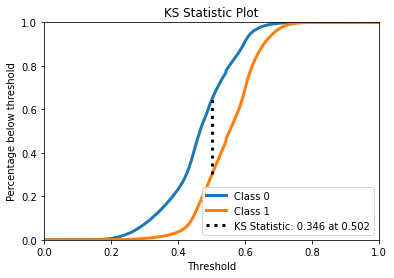

Performance no conjunto de treino:

Accuracy:         0.6724
Recall:           0.7043
Precision:        0.6620
F1:               0.6825
AUROC:            0.7388
AUPR:             0.7202


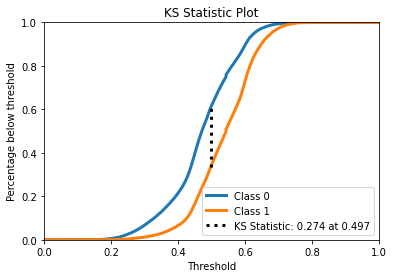

Performance no conjunto de validação:

Accuracy:         0.6369
Recall:           0.6571
Precision:        0.6315
F1:               0.6440
AUROC:            0.6871
AUPR:             0.6677


In [ ]:
    #buff model
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
    mlp_clf_buff = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_sklearn_compatible_model_5, 
                          batch_size=32, epochs=100,
                          verbose=1, callbacks=[es])
    mlp_clf_buff._estimator_type = "classifier"
    mlp_clf_buff.fit(train_X, train_Y)
    mlp_clf_buff.model.save('buff_model.h5')
    mlp_pred_class = mlp_clf_buff.predict(train_X)
    mlp_pred_scores = mlp_clf_buff.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf_buff.predict(validation_X)
    mlp_pred_scores = mlp_clf_buff.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)